封装算法包：

get_maxs_weight

get_mvar_weight

get_target_risk_weight

get_target_return_weight

get_target_averse_weight

plot_efficent_frontier

2022-07-28新增:

get_maxs_weight、get_mvar_weight、get_target_risk_weight、get_target_return_weight、get_target_averse_weight、plot_efficent_frontier增加返回值

get_target_risk_weight、get_target_return_weight 增加返回值条件




In [54]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.interpolate as sci
import pyodbc

In [55]:
def get_return(df):
    # 计算收益率（对数形式）
    df = df/df.iloc[0]*100 # 统一缩放到100为基点
    log_ret = np.log(df/df.shift())
    log_ret.dropna(inplace=True)
    stock_number = log_ret.shape[1]
    return log_ret,stock_number



In [56]:
def statistics(weights,expected_return,ret_cov,rf):
    '''
    本次计算，期望收益率均使用历史平均收益率
    '''
    weights = np.array(weights)
    pret = np.sum(expected_return * weights*252) 
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret_cov*252 , weights)))
    return np.array([pret, pvol, (pret-rf) / pvol])


In [57]:
def min_func_sharpe(weights,expected_return,ret_cov,rf):
    return -statistics(weights,expected_return,ret_cov,rf)[2]
def min_func_variance(weights,expected_return,ret_cov,rf):
    return statistics(weights,expected_return,ret_cov,rf)[1] ** 2
def min_func_return(weights,expected_return,ret_cov,rf):
    return -statistics(weights,expected_return,ret_cov,rf)[0]
def risk_averse(weights,expected_return,ret_cov,rf,lamb):
    return -statistics(weights,expected_return,ret_cov,rf)[0]+lamb*statistics(weights,expected_return,ret_cov,rf)[1]**2

In [124]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf
'''
def get_maxs_weight(df,bnds,rf):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    fun=min_func_sharpe
    opt = sco.minimize(fun,x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                   bounds=bnds, constraints=cons)
    return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)

In [125]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf
'''
def get_mvar_weight(df,bnds,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    fun=min_func_variance
    opt = sco.minimize(fun,x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                   bounds=bnds, constraints=cons)
    return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)

In [126]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf)
增加返回条件：与目标值不可偏差超过0.01
'''
def get_target_risk_weight(df,bnds,target_risk,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'ineq', 'fun': lambda x:  -statistics(x,expected_return,ret_cov,rf)[1] + target_risk},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    fun=min_func_return
    opt = sco.minimize(fun,x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                   bounds=bnds, constraints=cons)
    #--------------------20220728修改
    if abs(statistics(opt['x'],expected_return,ret_cov,rf)[1]-target_risk)>0.001:
        print('无法找到最优解')
    else:
        return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)
    #--------------------
    

In [127]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf)
增加返回条件：与目标值不可偏差超过0.01
'''
def get_target_return_weight(df,bnds,target_return,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'ineq', 'fun': lambda x:  statistics(x,expected_return,ret_cov,rf)[0] - target_return},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    opt = sco.minimize(min_func_variance, stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                           bounds=bnds, constraints=cons)
    #--------------------20220728修改
    if abs(statistics(opt['x'],expected_return,ret_cov,rf)[0]-target_return)>0.001:
        print('无法找到最优解')
    else:
        return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf)
    #------------------------
   

In [173]:
'''
增加返回值：statistics(opt['x'],expected_return,ret_cov,rf),-risk_averse(opt['x'],expected_return,ret_cov,rf,lamb)
'''
def get_target_averse_weight(df,bnds,lamb,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = bnds
    opt = sco.minimize(risk_averse, stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf,lamb), method='SLSQP',
                           bounds=bnds, constraints=cons)
    
 
    return opt['x'],statistics(opt['x'],expected_return,ret_cov,rf),-risk_averse(opt['x'],expected_return,ret_cov,rf,lamb)
    
   
    
   

In [174]:
'''
有效边界中增加返回值：每个点对应的res['x']
'''
def min_func_port(weights,expected_return,ret_cov,rf):
    return statistics(weights,expected_return,ret_cov,rf)[1]

def plot_efficent_frontier(df,bnds,rf=0):
    log_ret,stock_number=get_return(df)
    expected_return=log_ret.mean()
    ret_cov=log_ret.cov()
   # prets,pvols=get_distribution(log_ret)
    ret_min=min(log_ret.mean()*252)
  
    ret_max=max(log_ret.mean()*252)

    trets = np.linspace(ret_min,ret_max,50)
    tvols = []
    stats=[]
    for tret in trets:
        cons = ({'type': 'eq', 'fun': lambda x:  statistics(x,expected_return,ret_cov,rf)[0] - tret},
                {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
        bnds = bnds
        res = sco.minimize(min_func_port, x0=stock_number * [1. / stock_number,],args=(expected_return,ret_cov,rf), method='SLSQP',
                           bounds=bnds, constraints=cons)
        
        tvols.append(res['fun'])
       #----------------20220728新增
        stats.append(res['x'])
        #--------------------------
    tvols = np.array(tvols)
    ind = np.argmin(tvols)
    
    evols = tvols[ind:]  # 有效边界
    erets = trets[ind:]  # 有效边界
    #tck = sci.splrep(evols, erets)  # 有效边界插值
    plt.scatter(evols, erets,marker='x')

                # efficient frontier
    plt.grid(True)
   # plt.axhline(0, color='k', ls='--', lw=2.0)
  #  plt.axvline(0, color='k', ls='--', lw=2.0)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
     #----------------20220728新增stats[ind:]
    return evols,erets,stats[ind:]
    
  



------------测试样例，不用封装

In [186]:
def read_data(BeginDate,EndDate):
    sql_conn = pyodbc.connect('DRIVER={SQL Server Native Client 11.0};SERVER=10.101.0.213; DATABASE=JYDB;UID=design_read;PWD=Hello@design') 
    dfQuery='''
    select a.TradingDay,a.ClosePrice HS300,c.ClosePrice CYBZ from QT_IndexQuote  a  
    join QT_IndexQuote c on  a.TradingDay=c.TradingDay
    where a.InnerCode=3145  and c.InnerCode=39144 and a.TradingDay between '{}' and '{}'

    '''.format(pd.to_datetime(BeginDate),pd.to_datetime(EndDate))
    df=pd.read_sql(dfQuery,sql_conn,index_col='TradingDay')
    return df


In [187]:
BeginDate='2020-1-1'
EndDate='2021-12-31'
df=read_data(BeginDate,EndDate)
bnds = tuple((0, 1) for _ in range(df.shape[1]))

In [188]:
#优化目标1：最大夏普
rf=0
print("优化目标1：最大夏普:",get_maxs_weight(df,bnds,rf))
#优化目标2：最小波动率
print("优化目标2：最小波动率:",get_mvar_weight(df,bnds))
#优化目标3：给定波动率，最大化收益率
target_risk=0.1
print("优化目标3：给定波动率，最大化收益率:",get_target_risk_weight(df,bnds,target_risk))
#优化目标4：给定收益，最小化波动率
target_return=0.4
print("优化目标4：给定收益，最小化波动率:",get_target_return_weight(df,bnds,target_return))
#优化目标5：给定风险厌恶系数
lamb=0
print("优化目标5：给定风险厌恶系数:",get_target_averse_weight(df,bnds,lamb))

优化目标1：最大夏普: (array([0.50759072, 0.49240928]), array([0.17826131, 0.35621483, 0.50043204]))
优化目标2：最小波动率: (array([0.9941306, 0.0058694]), array([0.15415615, 0.33125675, 0.46536757]))
无法找到最优解
优化目标3：给定波动率，最大化收益率: None
无法找到最优解
优化目标4：给定收益，最小化波动率: None
优化目标5：给定风险厌恶系数: (array([0., 1.]), array([0.20340942, 0.42586911, 0.47763367]), 0.2034094248594693)


(array([0.33126052, 0.33127987, 0.33139034, 0.33159182, 0.33188414,
        0.33226708, 0.33274032, 0.33330347, 0.33395608, 0.33469762,
        0.3355275 , 0.33644508, 0.33744964, 0.33854039, 0.33971652,
        0.34097714, 0.34232131, 0.34374805, 0.34525635, 0.34684513,
        0.3485133 , 0.35025971, 0.35208322, 0.35398263, 0.35595671,
        0.35800424, 0.36012396, 0.36231461, 0.36457491, 0.36690356,
        0.36929929, 0.37176078, 0.37428675, 0.37687589, 0.37952692,
        0.38223854, 0.38500947, 0.38783846, 0.39072422, 0.39366552,
        0.39666112, 0.3997098 , 0.40281035, 0.40596158, 0.40916233,
        0.41241144, 0.41570778, 0.41905023, 0.4224377 , 0.42586911]),
 array([0.15386536, 0.15487646, 0.15588756, 0.15689867, 0.15790977,
        0.15892087, 0.15993198, 0.16094308, 0.16195418, 0.16296529,
        0.16397639, 0.16498749, 0.1659986 , 0.1670097 , 0.1680208 ,
        0.16903191, 0.17004301, 0.17105411, 0.17206522, 0.17307632,
        0.17408742, 0.17509853, 0.17610963, 0.

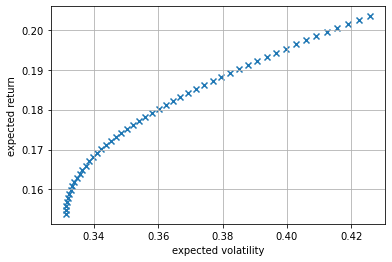

In [189]:
plot_efficent_frontier(df,bnds)

In [190]:
BeginDate='2021-1-31'
EndDate='2022-3-31'
df=read_data(BeginDate,EndDate)
bnds = tuple((0, 1) for _ in range(df.shape[1]))

In [191]:
#优化目标1：最大夏普
rf=0.01
print("优化目标1：最大夏普:",get_maxs_weight(df,bnds,rf))
#优化目标2：最小波动率
print("优化目标2：最小波动率:",get_mvar_weight(df,bnds))
#优化目标3：给定波动率，最大化收益率
target_risk=0.24
print("优化目标3：给定波动率，最大化收益率:",get_target_risk_weight(df,bnds,target_risk))
#优化目标4：给定收益，最小化波动率
target_return=0
print("优化目标4：给定收益，最小化波动率:",get_target_return_weight(df,bnds,target_return))
#优化目标5：给定风险厌恶系数
lamb=-0.3
print("优化目标5：给定风险厌恶系数:",get_target_averse_weight(df,bnds,lamb))

优化目标1：最大夏普: (array([0., 1.]), array([0.1242343 , 0.30385967, 0.37594428]))
优化目标2：最小波动率: (array([0.69589834, 0.30410166]), array([-0.0743859 ,  0.28116526, -0.26456292]))
无法找到最优解
优化目标3：给定波动率，最大化收益率: None
优化目标4：给定收益，最小化波动率: (array([0.43527517, 0.56472483]), array([-1.79679882e-11,  2.84457568e-01, -6.31657943e-11]))
优化目标5：给定风险厌恶系数: (array([0., 1.]), array([0.1242343 , 0.30385967, 0.4088542 ]), 0.15193351046406942)


(array([0.28116546, 0.28118978, 0.28125471, 0.2813602 , 0.28150623,
        0.28169271, 0.28191958, 0.28218673, 0.28249405, 0.28284141,
        0.28322867, 0.28365565, 0.28412218, 0.28462807, 0.28517311,
        0.28575706, 0.2863797 , 0.28704077, 0.28774001, 0.28847714,
        0.28925187, 0.2900639 , 0.29091291, 0.29179859, 0.2927206 ,
        0.29367859, 0.29467223, 0.29570114, 0.29676496, 0.29786332,
        0.29899584, 0.30016213, 0.30136179, 0.30259444, 0.30385967]),
 array([-0.07380914, -0.06798433, -0.06215952, -0.05633472, -0.05050991,
        -0.0446851 , -0.0388603 , -0.03303549, -0.02721068, -0.02138588,
        -0.01556107, -0.00973626, -0.00391145,  0.00191335,  0.00773816,
         0.01356297,  0.01938777,  0.02521258,  0.03103739,  0.0368622 ,
         0.042687  ,  0.04851181,  0.05433662,  0.06016142,  0.06598623,
         0.07181104,  0.07763585,  0.08346065,  0.08928546,  0.09511027,
         0.10093507,  0.10675988,  0.11258469,  0.11840949,  0.1242343 ]),
 [array([

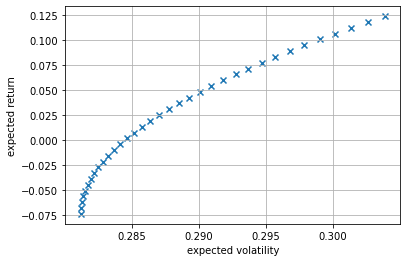

In [192]:
plot_efficent_frontier(df,bnds)

In [193]:
BeginDate='2021-1-31'
EndDate='2021-6-30'
df=read_data(BeginDate,EndDate)
bnds = tuple((0, 1) for _ in range(df.shape[1]))

In [194]:
#优化目标1：最大夏普
rf=0
print("优化目标1：最大夏普:",get_maxs_weight(df,bnds,rf))
#优化目标2：最小波动率
print("优化目标2：最小波动率:",get_mvar_weight(df,bnds))
#优化目标3：给定波动率，最大化收益率
target_risk=0.2
print("优化目标3：给定波动率，最大化收益率:",get_target_risk_weight(df,bnds,target_risk))
#优化目标4：给定收益，最小化波动率
target_return=0.1
print("优化目标4：给定收益，最小化波动率:",get_target_return_weight(df,bnds,target_return))
#优化目标5：给定风险厌恶系数
lamb=1
print("优化目标5：给定风险厌恶系数:",get_target_averse_weight(df,bnds,lamb))

优化目标1：最大夏普: (array([0., 1.]), array([0.28577557, 0.17950817, 1.59199202]))
优化目标2：最小波动率: (array([0.30689781, 0.69310219]), array([0.16905738, 0.17271067, 0.97884737]))
无法找到最优解
优化目标3：给定波动率，最大化收益率: None
无法找到最优解
优化目标4：给定收益，最小化波动率: None
优化目标5：给定风险厌恶系数: (array([0., 1.]), array([0.28577557, 0.17950817, 1.59199202]), 0.2535523865977972)


(array([0.17271071, 0.17274369, 0.17283792, 0.17299332, 0.17320971,
        0.17348687, 0.1738245 , 0.17422226, 0.17467973, 0.17519645,
        0.17577189, 0.17640548, 0.17709659, 0.17784456, 0.17864867,
        0.17950817]),
 array([0.16935227, 0.17711382, 0.18487538, 0.19263693, 0.20039848,
        0.20816004, 0.21592159, 0.22368314, 0.2314447 , 0.23920625,
        0.2469678 , 0.25472936, 0.26249091, 0.27025246, 0.27801402,
        0.28577557]),
 [array([0.30612245, 0.69387755]),
  array([0.28571429, 0.71428571]),
  array([0.26530612, 0.73469388]),
  array([0.24489796, 0.75510204]),
  array([0.2244898, 0.7755102]),
  array([0.20408163, 0.79591837]),
  array([0.18367347, 0.81632653]),
  array([0.16326531, 0.83673469]),
  array([0.14285714, 0.85714286]),
  array([0.12244898, 0.87755102]),
  array([0.10204082, 0.89795918]),
  array([0.08163265, 0.91836735]),
  array([0.06122449, 0.93877551]),
  array([0.04081633, 0.95918367]),
  array([0.02040816, 0.97959184]),
  array([0., 1.])])

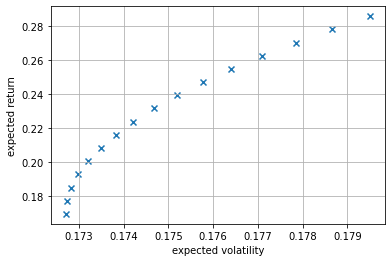

In [195]:
plot_efficent_frontier(df,bnds)